In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

/home/vishnu/anaconda3/envs/cl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
torch.manual_seed(42)

In [4]:
# Load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
classes = trainset.classes

In [6]:
# Define a neural network model with dropout
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = Net().to(device)

In [7]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [8]:
# Train the model
epochs = 10
train_losses = []
test_losses = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(trainloader))

    # Calculate test loss
    net.eval()
    test_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    test_losses.append(test_loss / len(testloader))
    net.train()
    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {running_loss / len(trainloader)}, Test Loss: {test_loss / len(testloader)}')


Epoch 1/10, Training Loss: 1.3839041517972945, Test Loss: 1.0748702961206436
Epoch 2/10, Training Loss: 1.0220356696844102, Test Loss: 0.9048926246166229
Epoch 3/10, Training Loss: 0.8716785290241241, Test Loss: 0.8365739691257477
Epoch 4/10, Training Loss: 0.7657968549728393, Test Loss: 0.8037732422351838
Epoch 5/10, Training Loss: 0.6718338989019393, Test Loss: 0.7617559266090393
Epoch 6/10, Training Loss: 0.5870737529993058, Test Loss: 0.74104645550251
Epoch 7/10, Training Loss: 0.5127431104183197, Test Loss: 0.7797404044866562
Epoch 8/10, Training Loss: 0.4460088005959988, Test Loss: 0.7782871705293656
Epoch 9/10, Training Loss: 0.38405759865045547, Test Loss: 0.7734433808922767
Epoch 10/10, Training Loss: 0.33827542698383334, Test Loss: 0.8204206413030625


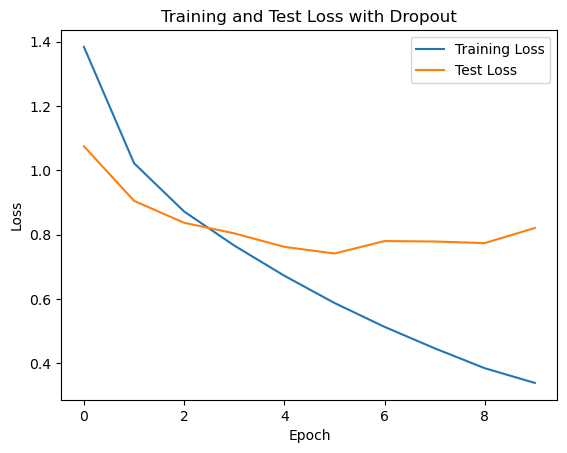

In [9]:
# Plot the training and test loss
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss with Dropout')
plt.show()